# Introduction

- A crisis in the financial market can be defined as a period of instability and uncertainty that could have been triggered due to a variety of factors. Typically, during a crisis period, a high degree of volatility is witnessed leading to constant shifts in investor sentiment.
- For the purpose of this project, a crises has been defined as a 20% decline in S&P500 from its recent peak. It ends with the next bull market , which is a 20% rise in the S&P500 from its recent trough.

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers = pd.read_html(io=url)[0]["Symbol"].to_list()
tickers = [t.replace(".", "-") for t in tickers]


def get_data(tickers, index, start, end, file):
    (
        yf.download(tickers=tickers, start=start, end=end)["Adj Close"]
        .pct_change()
        .join(
            other=(
                yf.download(tickers=index, start="1900-01-01", end=end)[
                    ["Close"]
                ].rename(columns={"Close": index})
            ),
            how="outer",
        )
        .to_csv(file)
    )


get_data(
    tickers=tickers,
    index="^GSPC",
    start="1980-01-01",
    end="2023-12-31",
    file="sp500.csv",
)

sp500 = pd.read_csv(
    filepath_or_buffer="sp500.csv", parse_dates=["Date"], index_col=["Date"]
).rename_axis(columns="Ticker")


print(sp500.iloc[-5:, -5:])

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 315550800, endDate = 1703998800")
/var/folders/1l/bw0s2klx3tzbnh229q3r5vr80000gn/T/ipykernel_43277/2540705355.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()
[*********************100%%**********************]  1 of 1 completed


Ticker           YUM       ZBH      ZBRA       ZTS        ^GSPC
Date                                                           
2023-12-22  0.000154  0.007605  0.015454  0.001644  4754.629883
2023-12-26  0.002000  0.009142  0.022605  0.002667  4774.750000
2023-12-27  0.004453 -0.002388  0.001053  0.007161  4781.580078
2023-12-28 -0.002446  0.004128 -0.001595  0.001321  4783.350098
2023-12-29  0.001073  0.000576 -0.007336  0.001065  4769.830078


# Defining Crisis Period

In [2]:
import pandas as pd


df = pd.read_csv("sp500.csv", parse_dates=['Date'], index_col="Date")
GSPC = "^GSPC"  

def cris_period(df, GSPC):
    df = df[df.index.year >= 1980]
    
    cris_periods = []
    in_cris = False
    cris_start_date = None
    
    index_peak = df[GSPC].iloc[0]
    index_trough = df[GSPC].iloc[0]
    
    for date, row in df.iterrows():
        curr_price = row[GSPC]
        
        if pd.isna(curr_price):
            continue
        
        if not in_cris and curr_price <= index_peak * 0.8:
            in_cris = True
            cris_start_date = date
            index_trough = curr_price
            
        elif in_cris and curr_price < index_trough:
            index_trough = curr_price
            
        elif in_cris and curr_price >= index_trough * 1.2:
            cris_periods.append((cris_start_date.strftime('%Y-%m-%d'), date.strftime('%Y-%m-%d')))
            in_cris = False
            index_peak = curr_price
            
        elif curr_price > index_peak:
            index_peak = curr_price
    
    if in_cris:
        last_date = df.index[-1]
        cris_periods.append((cris_start_date.strftime('%Y-%m-%d'), last_date.strftime('%Y-%m-%d')))
    
    return cris_periods


cris_periods = cris_period(df, GSPC)

print("Crisis Periods:")
for start, end in cris_periods:
    print(f"Start Date: {start}   |   End Date: {end}")


Crisis Periods:
Start Date: 1982-02-22   |   End Date: 1982-09-14
Start Date: 1987-10-19   |   End Date: 1988-03-08
Start Date: 2001-03-12   |   End Date: 2001-12-05
Start Date: 2002-07-10   |   End Date: 2002-08-22
Start Date: 2008-07-09   |   End Date: 2008-12-08
Start Date: 2009-02-23   |   End Date: 2009-03-23
Start Date: 2020-03-12   |   End Date: 2020-04-08
Start Date: 2022-06-13   |   End Date: 2023-06-08


We have identified 8 distinct crises periods between 1980 and 2023. The corresponding dates and the possible reasons could be defined as follows:
1) Feb 22,1982 - Sept 14,1982 : Latin American Debt Crises
2) Oct 19,1987 - Mar 8,1988 : Black Monday
3) Mar 12,2001 - Dec 5, 2001 : Dot-com Bubble burst
4) July 10, 2002 - Aug 22, 2002 : Corporate Accounting Scandals
5) July 9,2008 - Dec 8, 2008 : Global Financial Crises
6) Feb 23, 2009 - Mar 23, 2009 : Late stages of GFC
7) Mar 12, 2020 - Apr 8, 2020 : Covid-19 Pandemic
8) Jun 13, 2022 - Jun 8, 2023 : Effects of some economic and financial developments

# Correlation Matrix during Crisis Period

In [3]:
import pandas as pd

def corr_in_cris(df, cris_period):
    for start_date, end_date in cris_period(df, GSPC):  
        crisis_data = df.loc[start_date:end_date]
        clean_data = crisis_data.dropna(axis=1, how='any').drop(columns=[GSPC], errors='ignore')
        correlation_matrix = clean_data.corr()

        print(f"Correlation matrix for crisis period {start_date} to {end_date}:")
        print(correlation_matrix.iloc[:5, :5]) 
        
corr_in_cris(sp500, cris_period)


Correlation matrix for crisis period 1982-02-22 to 1982-09-14:
Ticker      AAPL       ABT       ADI       ADM       ADP
Ticker                                                  
AAPL    1.000000  0.434997  0.348166  0.197129  0.257798
ABT     0.434997  1.000000  0.352206  0.216337  0.347300
ADI     0.348166  0.352206  1.000000  0.163415  0.195212
ADM     0.197129  0.216337  0.163415  1.000000  0.260624
ADP     0.257798  0.347300  0.195212  0.260624  1.000000
Correlation matrix for crisis period 1987-10-19 to 1988-03-08:
Ticker      AAPL       ABT      ADBE       ADI       ADM
Ticker                                                  
AAPL    1.000000  0.703399  0.666919  0.576343  0.723454
ABT     0.703399  1.000000  0.470931  0.502850  0.576410
ADBE    0.666919  0.470931  1.000000  0.593633  0.518882
ADI     0.576343  0.502850  0.593633  1.000000  0.355237
ADM     0.723454  0.576410  0.518882  0.355237  1.000000
Correlation matrix for crisis period 2001-03-12 to 2001-12-05:
Ticker       

# Correlation Summary Statistics during Crisis Period

In [4]:
import pandas as pd
import numpy as np

def corr_summstats(df, cris_period):
    corr_summ = []

    for start_date, end_date in cris_period:  
        crisis_data = df.loc[start_date:end_date]
        clean_data = crisis_data.dropna(axis=1, how='any').drop(columns=['^GSPC'], errors='ignore')
        
        clean_data = clean_data.dropna()

        correlation_matrix = clean_data.corr()

        corr_values = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)]

        corr_summ.append({
            'start_date': start_date,
            'end_date': end_date,
            'mean': corr_values.mean(),
            'median': np.median(corr_values),
        })

    summary_df = pd.DataFrame(corr_summ)

    summary_df = summary_df.dropna()

    return summary_df

cris_periods = cris_period(sp500, '^GSPC')  
corr_summ = corr_summstats(sp500, cris_periods)
print(corr_summ)


   start_date    end_date      mean    median
1  1987-10-19  1988-03-08  0.462574  0.481798
2  2001-03-12  2001-12-05  0.208645  0.193957
3  2002-07-10  2002-08-22  0.390405  0.406196
4  2008-07-09  2008-12-08  0.567747  0.576826
5  2009-02-23  2009-03-23  0.596499  0.625512
6  2020-03-12  2020-04-08  0.665958  0.706095
7  2022-06-13  2023-06-08  0.398994  0.400658


# Plot for Correlation Mean during Crisis

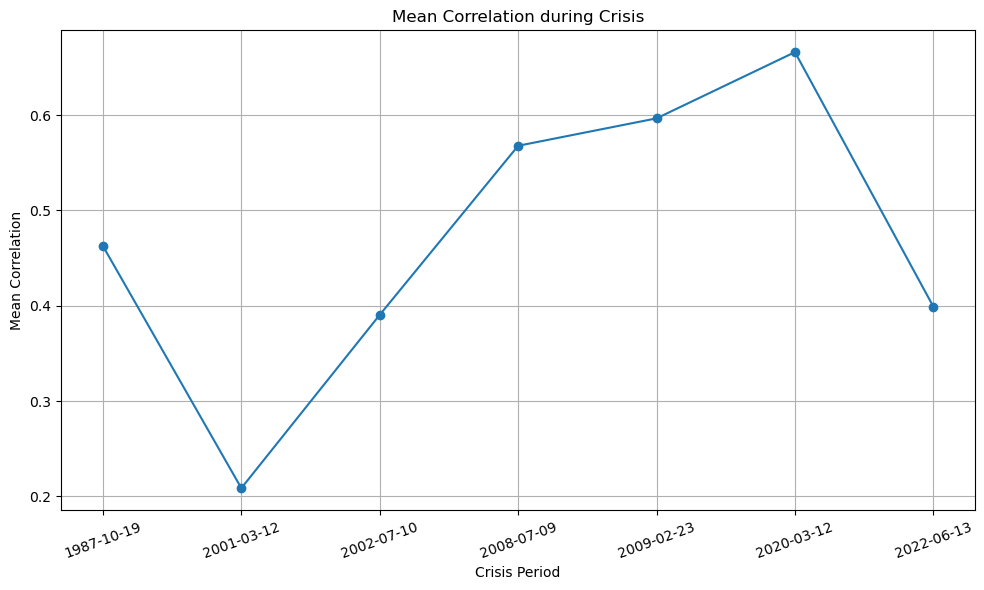

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(corr_summ['start_date'], corr_summ['mean'], marker='o', linestyle='-')
plt.title('Mean Correlation during Crisis')
plt.xlabel('Crisis Period')
plt.ylabel('Mean Correlation')
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot for Correlation Median during Crisis

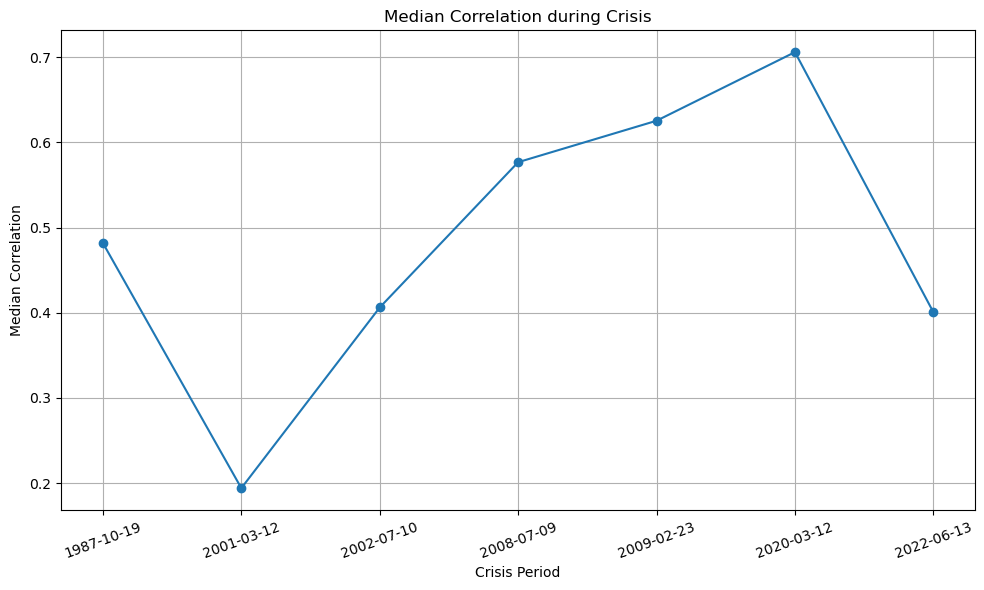

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(corr_summ['start_date'], corr_summ['median'], marker='o', linestyle='-')
plt.title('Median Correlation during Crisis')
plt.xlabel('Crisis Period')
plt.ylabel('Median Correlation')
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlation Interpretation

- A positive correlation between two assets suggests they tend to move in the same direction. The closer the correlation is to 1, the higher is the linear relationship between the two assets being analysed. 

- To better comprehend the correlation between the stocks in S&P500 during the crises periods, we have computed the mean and the median correlation of the  stocks. Both mean and median correlations are positive suggesting a positive linear relationship between the stocks.

- The mean correlation peaks at north of 0.6 while the median correlation peaks at 0.7. The line chart for the mean and median correlation signifies the correlation increasing, which is typically experienced during a crises period. 

# Beta Calculation

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed

Skipping calculation for GOOGL during ('1982-02-22', '1982-09-14') due to missing data
Skipping calculation for MSFT during ('1982-02-22', '1982-09-14') due to missing data
Skipping calculation for GOOGL during ('1987-10-19', '1988-03-08') due to missing data
Skipping calculation for GOOGL during ('2001-03-12', '2001-12-05') due to missing data
Skipping calculation for GOOGL during ('2002-07-10', '2002-08-22') due to missing data



/var/folders/1l/bw0s2klx3tzbnh229q3r5vr80000gn/T/ipykernel_43277/1304509838.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = crisis_data[ticker].pct_change().dropna()


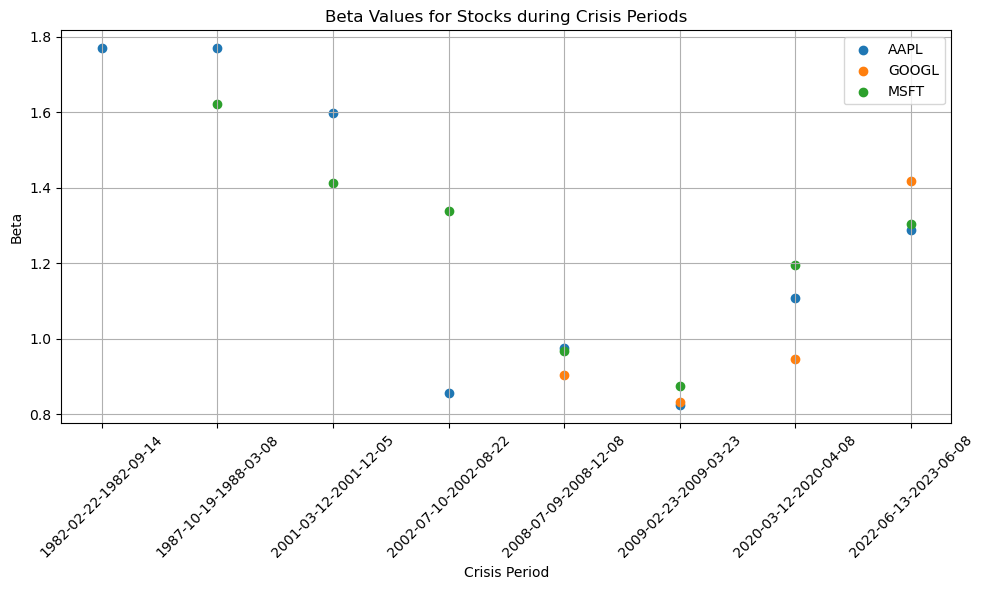

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def betas(tickers, index, cris_period):
    betas = {}
    for period in cris_period:
        start_date, end_date = period
        crisis_data = tickers.loc[start_date:end_date]
        market_data = index.loc[start_date:end_date]
        market_returns = market_data.pct_change().dropna()
        market_variance = np.var(market_returns)
        
        for ticker in crisis_data.columns:
            stock_returns = crisis_data[ticker].pct_change().dropna()
            
            if stock_returns.empty or market_returns.empty:
                print(f"Skipping calculation for {ticker} during {period} due to missing data")
                continue
            
            covariance = np.cov(stock_returns, market_returns)[0, 1]
            beta = covariance / market_variance
            betas[(ticker, period)] = beta
            
    return betas


tickers = yf.download(['AAPL', 'GOOGL', 'MSFT'], start='1982-01-01', end='2023-12-31', interval='1d')['Adj Close']
index = yf.download('^GSPC', start='1982-01-01', end='2023-12-31', interval='1d')['Adj Close']

crisis_periods = [
    ('1982-02-22', '1982-09-14'),
    ('1987-10-19', '1988-03-08'),
    ('2001-03-12', '2001-12-05'),
    ('2002-07-10', '2002-08-22'),
    ('2008-07-09', '2008-12-08'),
    ('2009-02-23', '2009-03-23'),
    ('2020-03-12', '2020-04-08'),
    ('2022-06-13', '2023-06-08')
]


betas_data = betas(tickers, index, crisis_periods)

crisis_periods_labels = [f"{start}-{end}" for start, end in crisis_periods]

plt.figure(figsize=(10, 6))
for i, ticker in enumerate(tickers.columns):
    x = range(len(crisis_periods_labels))
    y = [betas_data.get((ticker, period), np.nan) for period in crisis_periods] 
    plt.scatter(x, y, label=ticker)

plt.title('Beta Values for Stocks during Crisis Periods')
plt.xlabel('Crisis Period')
plt.ylabel('Beta')
plt.xticks(range(len(crisis_periods_labels)), crisis_periods_labels, rotation=45)  
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


*Interpretation*

- The beta value is a measure of a stock's volatility in comparison to the market as a whole. A beta value greater than 1 indicates that the stock is more volatile than the market, while a beta less than 1 indicates that the stock is less volatile.
- The chart displays a pattern where all three companies tend to have beta values above 1 during crisis periods, indicating that they are more volatile than the market.
- The chart's general market sensitivity pattern shows that, historically, during times of crisis, the three tech giants—Apple, Alphabet, and Microsoft—all show higher volatility than the market, as shown by beta values greater than 1. 
- These companies' beta values are gradually convergent, indicating that throughout recessions, their perceptions of risk are becoming more consistent. Apple's traditionally higher volatility is declining in relation to the market, while Microsoft continues to exhibit the lowest volatility during the observed crises, maintaining a continuous pattern of stability.